## 1. Import libraries

In [1]:
import rasterio
import numpy as np
import random
import os
import torch
import pandas as pd
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from loss_fn import FocalDiceIouLoss, iou_pytorch
import torchvision

## 2. Config

In [80]:
config={
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'seed':10,
    'val_size':0.3,
    'channels': [2,4,6],
    'experiment':True,
    'batch_size':8,
    'lr':1e-3,
    'epochs':100,
    'early_stopping':15,
    'inference':{
        'threshold':0.25
    }
}
DATAPATH='./dataset'
data_paths={
    'train_csv': DATAPATH+'/train_meta_2.csv',
    'test_csv': DATAPATH+'/test_meta.csv',
    'train_img':DATAPATH+'/train_img/',
    'train_mask':DATAPATH+'/train_mask/',
    'test_img':DATAPATH+'/test_img/',
}
train_csv = pd.read_csv(data_paths['train_csv'])
SAVE_PATH = './logs'
save_paths={
    'model':SAVE_PATH+'/models/',
    'val':SAVE_PATH+'/vals/'
}
# 시드 고정 함수
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
fix_seed(config['seed'])

## 3. Load Data

In [36]:
class Wildfire_Dataset(Dataset):
    def __init__(self, csv, transform_f=None,infer=False):
        self.csv = csv
        self.transform_f = transform_f
        self.infer = infer
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self,idx):
        img_path = self.csv.iloc[idx,0]
        # test인 경우 infer==True
        if self.infer:
            image = rasterio.open(data_paths['test_img']+img_path).read().transpose(1,2,0)[:,:,config['channels']]
            image = image/(2**16)
            image = image.astype(np.float32)
            if self.transform_f:
                image = self.transform_f(image=image)['image']
            return image
        # train인 경우
        image = rasterio.open(data_paths['train_img']+img_path).read().transpose(1,2,0)[:,:,config['channels']]
        image = image/(2**16)
        image = image.astype(np.float32)
        
        mask_path = self.csv.iloc[idx,1]
        mask = rasterio.open(data_paths['train_mask']+mask_path).read().transpose(1,2,0)
        if self.transform_f:
            augmented = self.transform_f(image=image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask, idx

In [37]:
base_transforms = {
    'train': A.Compose([
        # A.RandomBrightnessContrast(contrast_limit=(-0.2,-0.2),p=1),
        # A.GaussianBlur(),
        A.Normalize((0.5, ), (0.5, )),
        ToTensorV2(transpose_mask=True)
    ]),
    'valid':A.Compose([
        A.Normalize((0.5, ), (0.5, )),
        ToTensorV2(transpose_mask=True)
    ]),
    'test':A.Compose([
        A.Normalize((0.5, ), (0.5, )),      
        ToTensorV2(transpose_mask=True)
    ]),
}

In [38]:
fix_seed(config['seed'])
train_csv_, valid_csv_ = train_test_split(train_csv,test_size=config['val_size'],random_state=config['seed'])
train_dataset = Wildfire_Dataset(train_csv_,transform_f=base_transforms['train'],infer=False)
valid_dataset = Wildfire_Dataset(valid_csv_,transform_f=base_transforms['valid'],infer=False)
# B,C,H,W

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'],shuffle=False)
print(f'train size: {len(train_dataset)}, valid size: {len(valid_dataset)}')

train size: 14, valid size: 6


Augmentation Result Viewer

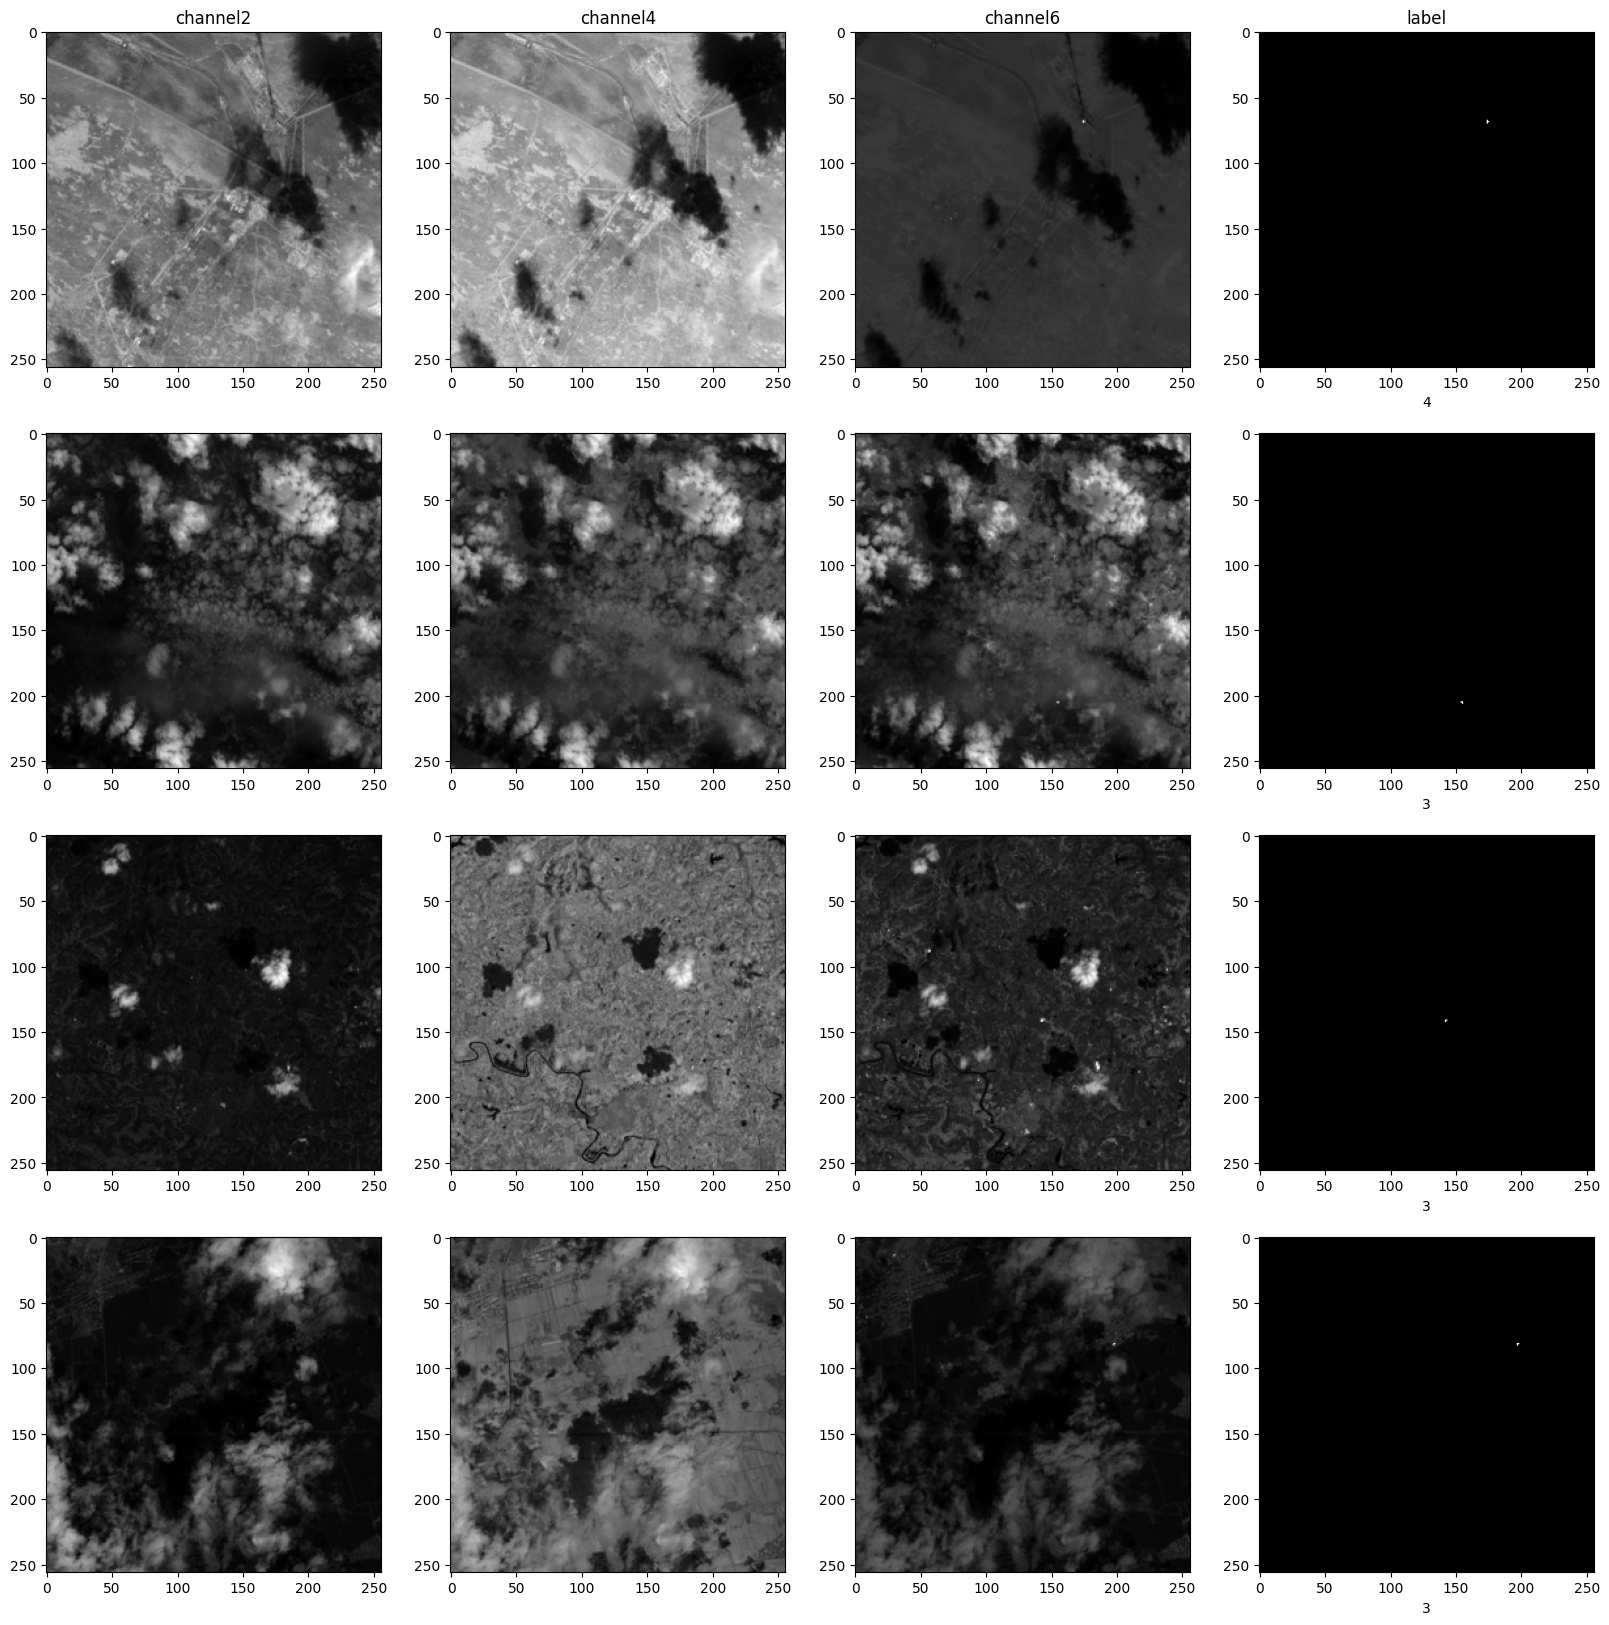

In [91]:
num_imgs_to_show=4
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+1)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('label')

cnt=0
for idx,(imgs, masks,img_idx) in enumerate(train_loader):
    for i in range(len(imgs)):
        for j in range(len(config['channels'])):
            axs[i,j].imshow(imgs[i,j,:,:],cmap='gray')
        axs[i,-1].imshow(masks[i,0,:,:],cmap='gray')
        axs[i,-1].set_xlabel(str(masks[i,0,:,:].sum().sum().item()))
        cnt+=1
        if cnt==num_imgs_to_show:
            break
    if cnt==num_imgs_to_show:
        break

## 4. Modeling

In [ ]:
from CWUnet import CWUnet

C:\Users\artis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
fix_seed(config['seed'])
model = CWUnet()
torch.save(model.state_dict(), save_paths["model"]+'/base_model.pt')

Loaded pretrained weights for efficientnet-b0


## 5. Train/Validation

In [85]:
def validation(config, model, criterion, valid_loader,epoch,val_pmap):
    model.eval()
    valid_loss=0
    valid_iou = 0
    valid_focal = 0
    valid_dice = 0
    
    y_pred_dict={}
    with torch.no_grad():
        for idx,(images, masks,img_idx) in tqdm(enumerate(valid_loader)):
            images = images.to(config['device'],dtype = torch.float32)
            masks = masks.to(config['device'],dtype = torch.float32)
            
            if epoch==0:
                for i in img_idx:
                    val_pmap[i.item()] = torch.zeros(images.shape[0],1,256,256)
                p_map = torch.zeros(images.shape[0],1,256,256)
            else:
                p_map= torch.concat([val_pmap[i.item()] for i in img_idx],axis=0)
            input_x = torch.concat([p_map,images],axis=1)
            
            outputs = model(input_x)
            
            with torch.no_grad():
                for idx_1,i in enumerate(img_idx):
                    val_pmap[i.item()] = torch.sigmoid(outputs[idx_1:idx_1+1,:,:,:])
            
            
            dice_loss,focal_loss,jaccard_loss, loss = criterion(outputs, masks)
            
            valid_loss += loss.item()
            valid_dice += dice_loss.item()
            valid_focal += focal_loss.item()
            valid_iou += 1-(jaccard_loss.item())
            
            for i in range(len(outputs)):
                y_pred = np.where(outputs[i,0,:,:].to('cpu')>config['inference']['threshold'],1,0).astype(np.uint8)
                y_pred_dict[str(idx*config['batch_size']+i)] = y_pred
        valid_save_path = save_paths['val']+f'epoch_{epoch}.pkl'
        joblib.dump(y_pred_dict,valid_save_path)
    return valid_loss/len(valid_loader), valid_iou/len(valid_loader), valid_dice/len(valid_loader),valid_focal/len(valid_loader), val_pmap

In [86]:
def train(config, model, train_loader, valid_loader):
    model = model.to(config['device'])
    es_count = 0
    min_val_loss = float('inf')
    best_model = None
    train_pmap = {}
    val_pmap = {}
    criterion = FocalDiceIouLoss()
    
    optimizer = torch.optim.Adam(model.parameters(),lr = config['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-8, verbose=True)
    print('***TRAINING START***')
    for epoch in range(config['epochs']):
        model.train()
        epoch_loss=0
        epoch_iou = 0
        epoch_dice=0
        epoch_focal =0
        for images, masks,img_idx in tqdm(train_loader):
            images = images.to(config['device'],dtype = torch.float32)
            masks = masks.to(config['device'],dtype = torch.float32)
            
            with torch.no_grad():
                if epoch==0:
                    for i in img_idx:
                        train_pmap[i.item()] = torch.zeros(images.shape[0],1,256,256)
                    p_map = torch.zeros(images.shape[0],1,256,256)
                else:
                    p_map= torch.concat([train_pmap[i.item()] for i in img_idx],axis=0)
                input_x = torch.concat([p_map,images],axis=1)
                
            
            optimizer.zero_grad()
            outputs = model(input_x)
            
            with torch.no_grad():
                for idx_1,i in enumerate(img_idx):
                    train_pmap[i.item()] = torch.sigmoid(outputs[idx_1:idx_1+1,:,:,:])
            
            dice_loss,focal_loss,jaccard_loss, loss = criterion(outputs, masks)
            loss.backward()
            
            epoch_dice += dice_loss.item()
            epoch_focal += focal_loss.item()
            epoch_iou += 1-(jaccard_loss.item())
            epoch_loss+=loss.item()
            
            optimizer.step()
            
        val_loss,val_iou,val_dice,val_focal,val_pmap = validation(config, model, criterion, valid_loader, epoch,val_pmap)
        
        es_count += 1
        if min_val_loss > val_loss:
            es_count = 0
            min_val_loss = val_loss
            best_model = model
            state_dict = model.state_dict()
            best_epoch = epoch+1
            print(f"Epoch [{best_epoch}] New Minimum Valid Loss!")
            print("..save current best model..")
            model_name = f'epoch {epoch}_current_best_model.pt'
            torch.save(state_dict, save_paths['model']+'/'+model_name)
        
        scheduler.step(val_loss)
        
        if es_count == config['early_stopping']:
            print(f"Early Stopping Count에 도달했습니다!")
            print(f"Epoch {epoch+1}, Best Epoch: {best_epoch}, ES Count: {es_count}\nTrain IoU: {epoch_iou/len(train_loader):6f}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Train Dice: {epoch_dice/len(train_loader):6f}, Train Focal: {epoch_focal/len(train_loader):6f}, Train Jaccard: {((1-epoch_iou)/len(train_loader)):6f}\nValid_IoU: {val_iou:6f}, Valid Loss: {val_loss:6f}, Valid_Dice: {val_dice:6f}, Valid_Focal: {val_focal:6f}, Valid Jaccard: {(1-val_iou):6f}")
            print("***TRAINING DONE***")
            return best_model
        print(f"Epoch {epoch+1}, Best Epoch: {best_epoch}, ES Count: {es_count}\nTrain IoU: {epoch_iou/len(train_loader):6f}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Train Dice: {epoch_dice/len(train_loader):6f}, Train Focal: {epoch_focal/len(train_loader):6f}, Train Jaccard: {((1-epoch_iou)/len(train_loader)):6f}\nValid_IoU: {val_iou:6f}, Valid Loss: {val_loss:6f}, Valid_Dice: {val_dice:6f}, Valid_Focal: {val_focal:6f}, Valid Jaccard: {(1-val_iou):6f}")
        print("------------------------------------------------------------------------------------")
    print(f"Early Stopping Count에 도달하지 않았습니다! \nEarly Stopping Count: {config['early_stopping']} Best Epoch: {best_epoch}")
    print("***TRAINING DONE***")
    return best_model

In [ ]:
fix_seed(config['seed']) # 결과 재현용
best_model = train(config,model,train_loader,valid_loader)

## 6. Inference

In [68]:
infer_model = CWUnet()
infer_model.load_state_dict(torch.load('./logs/models/epoch 6_current_best_model.pt'))

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [69]:
test_csv = pd.read_csv(data_paths['test_csv'])
test_dataset = Wildfire_Dataset(test_csv,transform_f=base_transforms['test'],infer=True)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [75]:
resize = torchvision.transforms.Resize(256)
def inference(model):
    model.to(config['device'])
    model.eval()
    y_pred_dict = {}
    with torch.no_grad():
        for idx,img in tqdm(enumerate(test_loader)):
            img = img.to(config['device'],dtype = torch.float32)
            
            # pytorch smp 라이브러리 모델은 predict 가능
            p_map = torch.zeros(img.shape[0],1,256,256)
            input_x = torch.concat([p_map,img],axis=1)
            y_pred = model(input_x)
            
            # 구현한 FCN은 그냥 output 찍는쪽으로
            # y_pred = model(img)
            y_pred = resize(y_pred)
            y_pred = np.where(y_pred[0, 0, :, :].to('cpu') > config['inference']['threshold'], 1, 0) # 임계값 처리
            y_pred = y_pred.astype(np.uint8)
            y_pred_dict[test_csv.loc[idx]['test_img']] = y_pred

        joblib.dump(y_pred_dict, './y_pred.pkl')

In [76]:
fix_seed(config['seed'])
inference(infer_model)

0it [00:00, ?it/s]

C:\Users\artis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
20it [00:02,  6.85it/s]


## 7. Validation Viewer

In [88]:
epoch_to_check = 0
num_imgs_to_show = 4
valid_save_path = save_paths['val']+f'epoch_{epoch_to_check}.pkl'
val_preds = joblib.load(valid_save_path)

In [ ]:
val_preds = joblib.load(valid_save_path)
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+2)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('label')
axs[0,i+2].set_title('pred')
cnt=0
for idx,(imgs, masks,img_idx) in enumerate(valid_loader):
    for i in range(len(imgs)):
        iou = iou_pytorch(torch.from_numpy(val_preds[str(idx*config['batch_size']+i)]).unsqueeze(0).unsqueeze(0),masks[i].unsqueeze(0),threshold=config['inference']['threshold'])
        for j in range(len(config['channels'])):
            axs[i,j].imshow(imgs[i,j,:,:],cmap='gray')
        axs[i,-3].set_xlabel(f'iou: {iou.item():6g}')
        axs[i,-2].imshow(masks[i,0,:,:],cmap='gray')
        axs[i,-2].set_xlabel(str(masks[i,0,:,:].sum().sum().item()))
        axs[i,4].imshow(val_preds[str(idx*config['batch_size']+i)],cmap='gray')
        axs[i,4].set_xlabel(str(val_preds[str(idx*config['batch_size']+i)].sum().sum()))
        cnt+=1
        if cnt==num_imgs_to_show:
            break
    if cnt==num_imgs_to_show:
        break

## 8. Inference Viewer

In [77]:
num_imgs_to_show = 4
test_save_path = './y_pred.pkl'
test_preds = joblib.load(test_save_path)

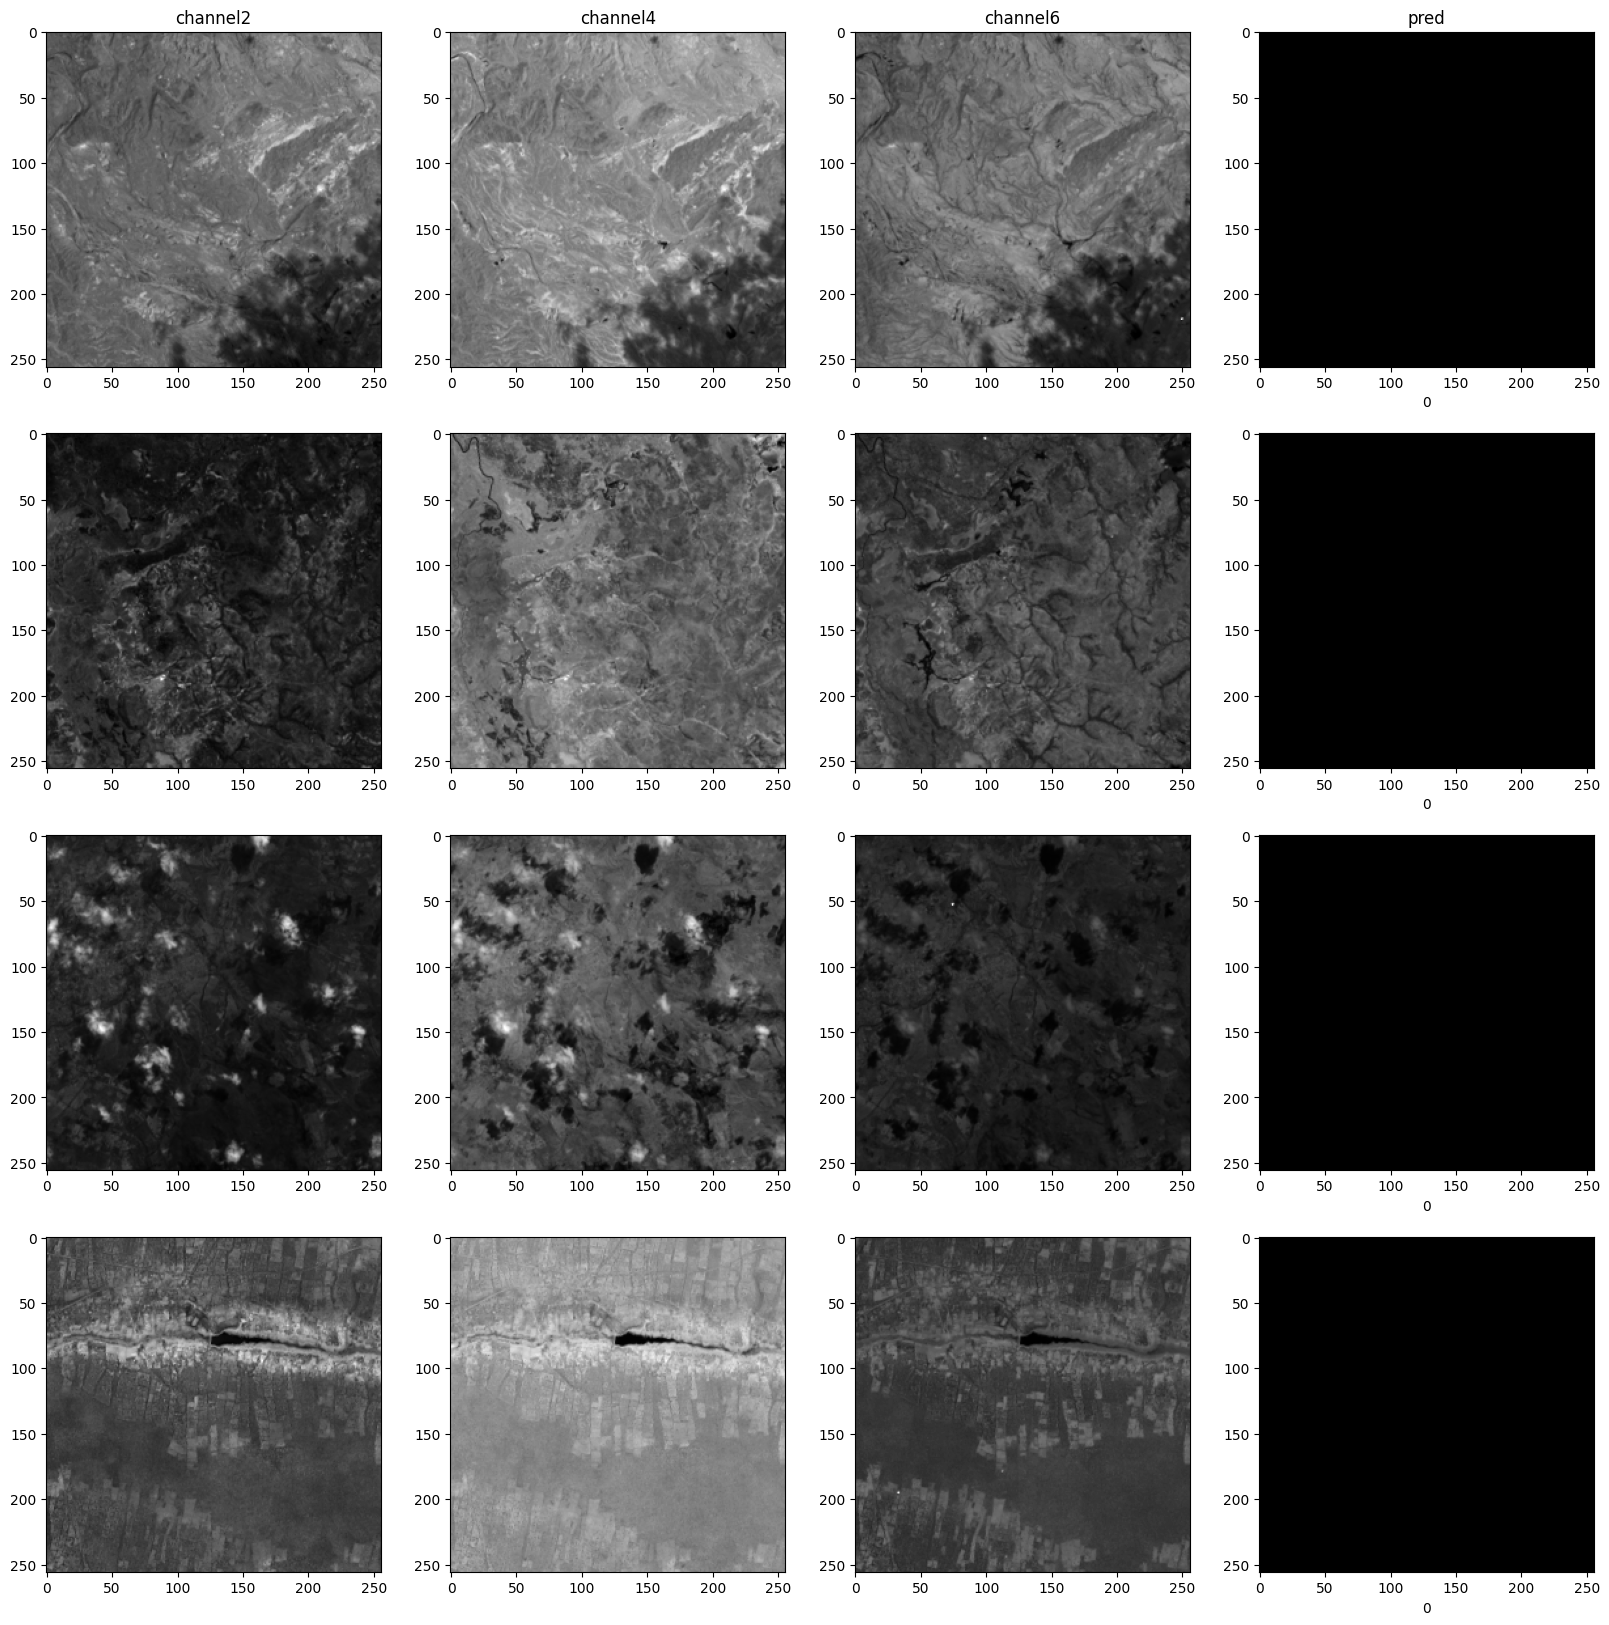

In [78]:
test_preds = joblib.load(test_save_path)
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+1)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('pred')
cnt=0
for (imgs) in (test_loader):
    for j in range(len(config['channels'])):
        axs[cnt,j].imshow(imgs[0,j,:,:],cmap='gray')
    axs[cnt,-1].imshow(test_preds[test_csv.loc[cnt]['test_img']],cmap='gray')
    axs[cnt,-1].set_xlabel(str(test_preds[test_csv.loc[cnt]['test_img']].sum().sum()))
    cnt+=1
    if cnt==num_imgs_to_show:
        break